<a href="https://colab.research.google.com/github/H-Freax/ML-000/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base

In [1]:
!pip install lightgbm xgboost catboost category-encoders sklearn pandas==1.1.5

     |████████████████████████████████| 65.7MB 54kB/s 
     |████████████████████████████████| 81kB 12.1MB/s 


In [2]:
import pandas as pd
import numpy as np

traincsv = pd.read_csv('/content/train_final.csv', engine='python')

testcsv = pd.read_csv('/content/test_final.csv', engine='python')



In [3]:
x_train = traincsv.drop(columns=['loan_status'])
x_test = testcsv.drop(columns=['loan_status'])

y_train = traincsv[['loan_status']]
y_test = testcsv[['loan_status']]

In [4]:
TRAIN_IDX=x_train.shape[0]
TEST_IDX = TRAIN_IDX + x_test.shape[0]

In [5]:
x = pd.concat([x_train, x_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

data = pd.concat([x, y], axis=1)

In [6]:
data.columns.to_list()

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec',
 'discrete_addr_state_1_one_hot',
 'discrete_addr_state_2_one_hot',
 'discrete_addr_state_3_one_hot',
 'discrete_addr_state_4_one_hot',
 'discrete_addr_state_5_one_hot',
 'discrete_addr_state_6_one_hot',
 'discrete_addr_state_7_one_hot',
 'discrete_addr_state_8_one_hot',
 'discrete_addr_state_9_one_hot',
 'discrete_addr_state_10_one_hot',
 'discrete_addr_state_11_one_hot',
 'discrete_addr_state_12_one_hot'

In [7]:
data['loan_status'].unique()

array([1, 0])

In [8]:
data['loan_status'].value_counts()

1    80014
0    19986
Name: loan_status, dtype: int64

# TreeBased Models

In [9]:
train = data.iloc[:TRAIN_IDX, :]
test = data.iloc[TRAIN_IDX:TEST_IDX, :]

In [10]:
import lightgbm as lgb
train_dataset = lgb.Dataset(train.drop(columns='loan_status'), train['loan_status'])
test_dataset = lgb.Dataset(test.drop(columns='loan_status'), test['loan_status'])

In [11]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric':'binary_error'}
num_round = 2000

In [12]:
model = lgb.train(param, train_dataset, num_boost_round=num_round, valid_sets=[train_dataset, test_dataset])

[1]	training's binary_error: 0.20424	valid_1's binary_error: 0.19548
[2]	training's binary_error: 0.20424	valid_1's binary_error: 0.19548
[3]	training's binary_error: 0.20424	valid_1's binary_error: 0.19548
[4]	training's binary_error: 0.20424	valid_1's binary_error: 0.19548
[5]	training's binary_error: 0.14838	valid_1's binary_error: 0.14168
[6]	training's binary_error: 0.112	valid_1's binary_error: 0.11048
[7]	training's binary_error: 0.099	valid_1's binary_error: 0.10016
[8]	training's binary_error: 0.09384	valid_1's binary_error: 0.09572
[9]	training's binary_error: 0.08812	valid_1's binary_error: 0.09036
[10]	training's binary_error: 0.08416	valid_1's binary_error: 0.08636
[11]	training's binary_error: 0.08172	valid_1's binary_error: 0.08476
[12]	training's binary_error: 0.08048	valid_1's binary_error: 0.08422
[13]	training's binary_error: 0.07882	valid_1's binary_error: 0.08354
[14]	training's binary_error: 0.07806	valid_1's binary_error: 0.0832
[15]	training's binary_error: 0.07

# A Wrapper

In [13]:
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import torch

import copy
cpu_count = 4
use_gpu = False
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    num_leaves: any = hp.choice('num_leaves', [64])
    metric: any = hp.choice('metric', ['binary_error'])
    num_round: any = hp.choice('num_rounds', [1000])
    objective: any = hp.choice('objective', ['binary'])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [14]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")


In [15]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

In [16]:
fitter = LGBFitter(label='loan_status')

In [17]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 2000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}

In [18]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [19]:
train.head(5)

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,discrete_addr_state_20_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,loan_status
0,55000.0,NaN,0.0,5.91,NaN,679.0,675.0,3600.0,3600.0,1.0,123.03,13.99,564.0,560.0,3600.0,30.0,30.0,NaN,7.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,65000.0,NaN,1.0,16.06,NaN,719.0,715.0,24700.0,24700.0,4.0,820.28,11.99,699.0,695.0,24700.0,6.0,NaN,NaN,22.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,63000.0,71000.0,0.0,10.78,13.85,699.0,695.0,20000.0,20000.0,0.0,432.66,10.78,704.0,700.0,20000.0,NaN,NaN,NaN,6.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,104433.0,NaN,1.0,25.37,NaN,699.0,695.0,10400.0,10400.0,3.0,289.91,22.45,704.0,700.0,10400.0,12.0,NaN,NaN,12.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,34000.0,NaN,0.0,10.20,NaN,694.0,690.0,11950.0,11950.0,0.0,405.18,13.44,759.0,755.0,11950.0,NaN,NaN,NaN,5.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [20]:
test.head(5)

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,discrete_addr_state_20_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,loan_status
0,35000.0,NaN,1.0,25.65,NaN,664.0,660.0,13000.0,13000.0,1.0,428.63,11.49,659.0,655.0,13000.0,3.0,3.0,NaN,12.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,50000.0,NaN,0.0,22.01,NaN,729.0,725.0,11000.0,11000.0,0.0,339.10,6.89,769.0,765.0,11000.0,NaN,NaN,NaN,25.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
2,100000.0,NaN,0.0,26.39,NaN,764.0,760.0,10000.0,10000.0,1.0,301.15,5.32,684.0,680.0,10000.0,NaN,NaN,NaN,23.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,55000.0,NaN,0.0,12.26,NaN,664.0,660.0,13800.0,13800.0,0.0,318.75,13.67,724.0,720.0,13800.0,55.0,55.0,NaN,13.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,50000.0,NaN,0.0,17.55,NaN,674.0,670.0,13550.0,13550.0,3.0,491.23,18.20,574.0,570.0,13550.0,29.0,82.0,NaN,7.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


# 直接进行处理

In [21]:
train_pred1, test_pred1, acc_result1, models1 = fitter.train_k_fold(kfold, train, test, params = params)

The minimum is attained in round 413
The minimum is attained in round 578
The minimum is attained in round 397
The minimum is attained in round 623
The minimum is attained in round 329


In [22]:
y_pred1 = models1[0].predict(test.drop(columns='loan_status'))
print('The rmse of prediction: %f'% (mean_squared_error(test['loan_status'], y_pred1)))

The rmse of prediction: 0.060010


# 进行数据分析

In [26]:
%matplotlib inline 
import seaborn as sns

In [27]:
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

In [28]:
onehotcol=['discrete_addr_state_1_one_hot',
 'discrete_addr_state_2_one_hot',
 'discrete_addr_state_3_one_hot',
 'discrete_addr_state_4_one_hot',
 'discrete_addr_state_5_one_hot',
 'discrete_addr_state_6_one_hot',
 'discrete_addr_state_7_one_hot',
 'discrete_addr_state_8_one_hot',
 'discrete_addr_state_9_one_hot',
 'discrete_addr_state_10_one_hot',
 'discrete_addr_state_11_one_hot',
 'discrete_addr_state_12_one_hot',
 'discrete_addr_state_13_one_hot',
 'discrete_addr_state_14_one_hot',
 'discrete_addr_state_15_one_hot',
 'discrete_addr_state_16_one_hot',
 'discrete_addr_state_17_one_hot',
 'discrete_addr_state_18_one_hot',
 'discrete_addr_state_19_one_hot',
 'discrete_addr_state_20_one_hot',
 'discrete_addr_state_21_one_hot',
 'discrete_addr_state_22_one_hot',
 'discrete_addr_state_23_one_hot',
 'discrete_addr_state_24_one_hot',
 'discrete_addr_state_25_one_hot',
 'discrete_addr_state_26_one_hot',
 'discrete_addr_state_27_one_hot',
 'discrete_addr_state_28_one_hot',
 'discrete_addr_state_29_one_hot',
 'discrete_addr_state_30_one_hot',
 'discrete_addr_state_31_one_hot',
 'discrete_addr_state_32_one_hot',
 'discrete_addr_state_33_one_hot',
 'discrete_addr_state_34_one_hot',
 'discrete_addr_state_35_one_hot',
 'discrete_addr_state_36_one_hot',
 'discrete_addr_state_37_one_hot',
 'discrete_addr_state_38_one_hot',
 'discrete_addr_state_39_one_hot',
 'discrete_addr_state_40_one_hot',
 'discrete_addr_state_41_one_hot',
 'discrete_addr_state_42_one_hot',
 'discrete_addr_state_43_one_hot',
 'discrete_addr_state_44_one_hot',
 'discrete_addr_state_45_one_hot',
 'discrete_addr_state_46_one_hot',
 'discrete_addr_state_47_one_hot',
 'discrete_addr_state_48_one_hot',
 'discrete_addr_state_49_one_hot',
 'discrete_application_type_1_one_hot',
 'discrete_application_type_2_one_hot',
 'discrete_emp_length_1_one_hot',
 'discrete_emp_length_2_one_hot',
 'discrete_emp_length_3_one_hot',
 'discrete_emp_length_4_one_hot',
 'discrete_emp_length_5_one_hot',
 'discrete_emp_length_6_one_hot',
 'discrete_emp_length_7_one_hot',
 'discrete_emp_length_8_one_hot',
 'discrete_emp_length_9_one_hot',
 'discrete_emp_length_10_one_hot',
 'discrete_emp_length_11_one_hot',
 'discrete_emp_length_12_one_hot',
 'discrete_grade_1_one_hot',
 'discrete_grade_2_one_hot',
 'discrete_grade_3_one_hot',
 'discrete_grade_4_one_hot',
 'discrete_grade_5_one_hot',
 'discrete_grade_6_one_hot',
 'discrete_grade_7_one_hot',
 'discrete_home_ownership_1_one_hot',
 'discrete_home_ownership_2_one_hot',
 'discrete_home_ownership_3_one_hot',
 'discrete_home_ownership_4_one_hot',
 'discrete_policy_code_1_one_hot',
 'discrete_purpose_1_one_hot',
 'discrete_purpose_2_one_hot',
 'discrete_purpose_3_one_hot',
 'discrete_purpose_4_one_hot',
 'discrete_purpose_5_one_hot',
 'discrete_purpose_6_one_hot',
 'discrete_purpose_7_one_hot',
 'discrete_purpose_8_one_hot',
 'discrete_purpose_9_one_hot',
 'discrete_purpose_10_one_hot',
 'discrete_purpose_11_one_hot',
 'discrete_purpose_12_one_hot',
 'discrete_pymnt_plan_1_one_hot',
 'discrete_sub_grade_1_one_hot',
 'discrete_sub_grade_2_one_hot',
 'discrete_sub_grade_3_one_hot',
 'discrete_sub_grade_4_one_hot',
 'discrete_sub_grade_5_one_hot',
 'discrete_sub_grade_6_one_hot',
 'discrete_sub_grade_7_one_hot',
 'discrete_sub_grade_8_one_hot',
 'discrete_sub_grade_9_one_hot',
 'discrete_sub_grade_10_one_hot',
 'discrete_sub_grade_11_one_hot',
 'discrete_sub_grade_12_one_hot',
 'discrete_sub_grade_13_one_hot',
 'discrete_sub_grade_14_one_hot',
 'discrete_sub_grade_15_one_hot',
 'discrete_sub_grade_16_one_hot',
 'discrete_sub_grade_17_one_hot',
 'discrete_sub_grade_18_one_hot',
 'discrete_sub_grade_19_one_hot',
 'discrete_sub_grade_20_one_hot',
 'discrete_sub_grade_21_one_hot',
 'discrete_sub_grade_22_one_hot',
 'discrete_sub_grade_23_one_hot',
 'discrete_sub_grade_24_one_hot',
 'discrete_sub_grade_25_one_hot',
 'discrete_sub_grade_26_one_hot',
 'discrete_sub_grade_27_one_hot',
 'discrete_sub_grade_28_one_hot',
 'discrete_sub_grade_29_one_hot',
 'discrete_sub_grade_30_one_hot',
 'discrete_sub_grade_31_one_hot',
 'discrete_sub_grade_32_one_hot',
 'discrete_sub_grade_33_one_hot',
 'discrete_sub_grade_34_one_hot',
 'discrete_sub_grade_35_one_hot',
 'discrete_term_1_one_hot',
 'discrete_term_2_one_hot']

In [29]:
an_train=train.copy()
an_train=an_train.drop(onehotcol, axis=1)


In [30]:
an_test=test.copy()
an_test=an_test.drop(onehotcol, axis=1)

In [31]:
an_train.head(5)

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,loan_status
0,55000.0,NaN,0.0,5.91,NaN,679.0,675.0,3600.0,3600.0,1.0,123.03,13.99,564.0,560.0,3600.0,30.0,30.0,NaN,7.0,0.0,1
1,65000.0,NaN,1.0,16.06,NaN,719.0,715.0,24700.0,24700.0,4.0,820.28,11.99,699.0,695.0,24700.0,6.0,NaN,NaN,22.0,0.0,1
2,63000.0,71000.0,0.0,10.78,13.85,699.0,695.0,20000.0,20000.0,0.0,432.66,10.78,704.0,700.0,20000.0,NaN,NaN,NaN,6.0,0.0,1
3,104433.0,NaN,1.0,25.37,NaN,699.0,695.0,10400.0,10400.0,3.0,289.91,22.45,704.0,700.0,10400.0,12.0,NaN,NaN,12.0,0.0,1
4,34000.0,NaN,0.0,10.20,NaN,694.0,690.0,11950.0,11950.0,0.0,405.18,13.44,759.0,755.0,11950.0,NaN,NaN,NaN,5.0,0.0,1


In [32]:
an_train.describe()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,loan_status
count,5.000000e+04,220.000000,50000.00000,49999.000000,220.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,26083.000000,15052.000000,9495.000000,50000.000000,50000.000000,50000.000000
mean,7.835886e+04,109248.802545,0.34738,19.080239,18.831864,698.404460,694.404300,14332.53650,14325.533000,0.620820,428.892109,11.986125,675.644860,658.428400,14332.53650,34.197485,44.214589,65.500790,11.944960,0.252820,0.795760
std,9.783053e+04,52319.230212,0.91874,9.802002,7.586033,31.180915,31.180139,8617.58487,8612.853833,0.906035,254.569184,4.182402,81.571458,133.005552,8617.58487,21.828204,21.352291,23.659021,5.676976,0.665455,0.403149
min,0.000000e+00,28000.000000,0.00000,0.000000,3.000000,664.000000,660.000000,1000.00000,950.000000,0.000000,14.770000,5.320000,0.000000,0.000000,1000.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.700000e+04,76000.000000,0.00000,12.410000,13.805000,674.000000,670.000000,7775.00000,7750.000000,0.000000,244.242500,9.170000,624.000000,620.000000,7775.00000,16.000000,27.000000,51.000000,8.000000,0.000000,1.000000
50%,6.500000e+04,99000.000000,0.00000,18.520000,17.940000,689.000000,685.000000,12000.00000,12000.000000,0.000000,369.520000,11.490000,689.000000,685.000000,12000.00000,31.000000,44.000000,67.000000,11.000000,0.000000,1.000000
75%,9.400000e+04,132700.000000,0.00000,25.320000,23.477500,714.000000,710.000000,20000.00000,20000.000000,1.000000,572.850000,14.330000,734.000000,730.000000,20000.00000,50.000000,63.000000,81.000000,15.000000,0.000000,1.000000
max,9.000000e+06,500000.000000,15.00000,999.000000,43.860000,850.000000,845.000000,35000.00000,35000.000000,5.000000,1354.660000,28.990000,850.000000,845.000000,35000.00000,152.000000,152.000000,120.000000,67.000000,23.000000,1.000000


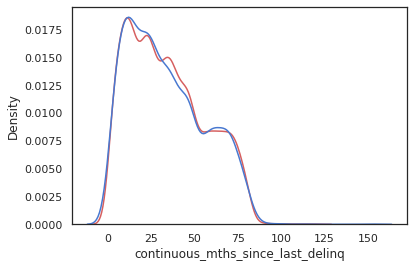

In [33]:

ax1=sns.kdeplot(an_train['continuous_mths_since_last_delinq'][an_train['loan_status']==1],color='r')
ax2=sns.kdeplot(an_train['continuous_mths_since_last_delinq'][an_train['loan_status']==0],color='b')

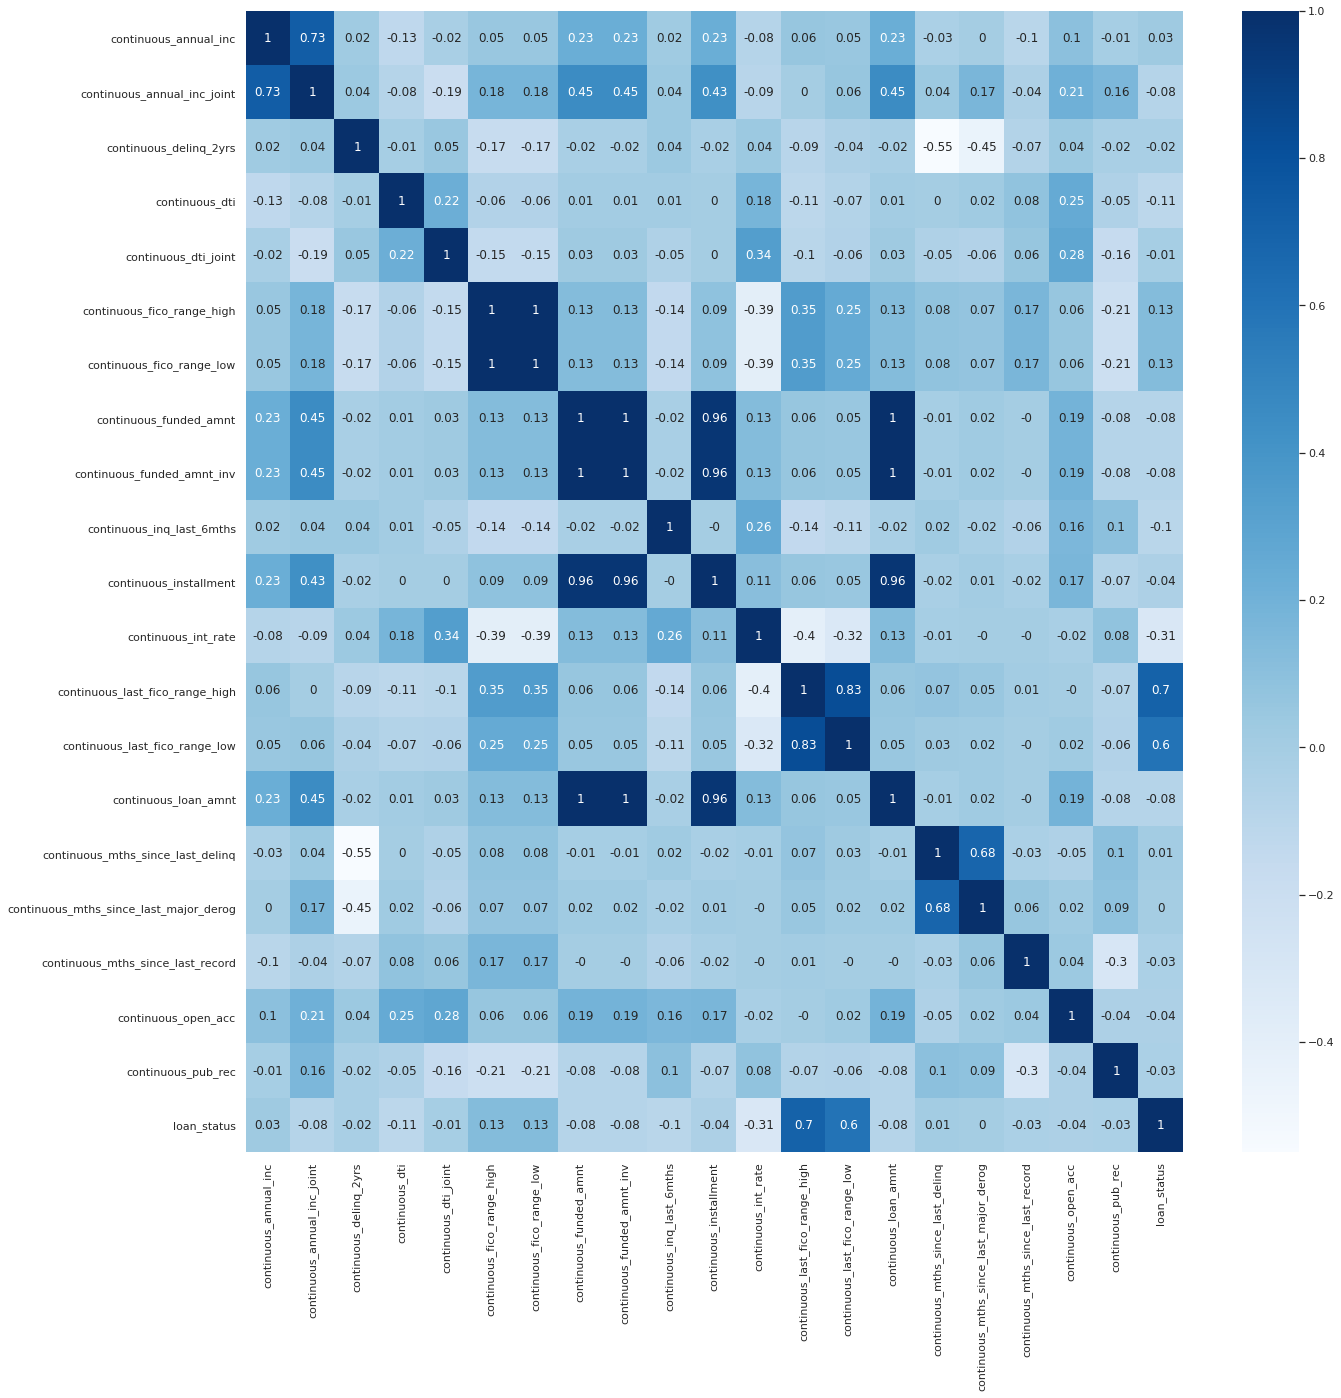

In [34]:
an_train

plt.figure(figsize=(21,21))
sns.heatmap(round(an_train.corr(),2), cmap='Blues', annot=True)
plt.show()

# 添加衍生变量

In [60]:
train1=train.copy()

train1['continuous_last_fico_range']=train1['continuous_fico_range_high']-train1['continuous_last_fico_range_high']
test1=test.copy()

test1['continuous_last_fico_range']=test1['continuous_fico_range_high']-test1['continuous_last_fico_range_high']

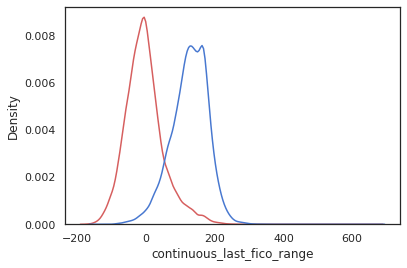

In [61]:
ax1=sns.kdeplot(train1['continuous_last_fico_range'][train1['loan_status']==1],color='r')
ax2=sns.kdeplot(train1['continuous_last_fico_range'][train1['loan_status']==0],color='b')


## 添加衍生变量后

In [63]:
#添加衍生变量后

train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train1, test1, params = params)

The minimum is attained in round 573
The minimum is attained in round 372
The minimum is attained in round 370
The minimum is attained in round 412
The minimum is attained in round 363


In [75]:
acc_result

[0.0736, 0.08089999999999997, 0.08340000000000003, 0.08340000000000003, 0.0796]

In [73]:
basepre=pd.DataFrame((test_pred1 > 0.5).astype(int))
base_acc_count=0
for i in range(len(pre)):
  if basepre[0][i] == test['loan_status'][i]:
    base_acc_count += 1
resbase=base_acc_count/len(basepre)*1.0
print(resbase)

0.91788


In [74]:
pre = pd.DataFrame((test_pred > 0.5).astype(int))
acc_count=0
for i in range(len(pre)):
  if pre[0][i] == test1['loan_status'][i]:
    acc_count += 1
res1=acc_count/len(pre)*1.0
print(res1)

0.91814


In [76]:
res1-resbase

0.00025999999999992696